#  Model selection: fit to liver cell types

In the current notebook, we run the inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 1293 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['sc','sn']

cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../seq-cme-technoise/polyA_ref/gg_200525_genome_polyA_cum_3'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']



In [4]:
loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[0]+'.loom' ]*len(cluster_names) + \
                 ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[1]+'.loom' ]*len(cluster_names) 


In [5]:
loom_filepaths

['/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [7]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [8]:
meta_str = '/home/ggorin/datasets/liver_andrews/GSE185477_Final_Metadata.txt'
meta = pd.read_csv(meta_str,sep='\t')

In [9]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C41_AAACCTGAGCCTTGAT,C41,428,199,32.087912,AAACCTGAGCCTTGAT,C41,C41_AAACCTGAGCCTTGAT,-0.009246,-0.016106,G1,C41,single_cell,11,InterHep,Hepatocyte,Hep_6,Hep_Unidentified,-3.321926,-6.397605
C41_AAACCTGAGGTCATCT,C41,275,181,19.666667,AAACCTGAGGTCATCT,C41,C41_AAACCTGAGGTCATCT,-0.018254,-0.027253,G1,C41,single_cell,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,14.034962,2.834506
C41_AAACCTGAGTCGCCGT,C41,632,264,15.703704,AAACCTGAGTCGCCGT,C41,C41_AAACCTGAGTCGCCGT,-0.010180,-0.027701,G1,C41,single_cell,13,Bcells,Bcells,Lymph_5,Lymph_Mature B cells,-1.928654,-7.027950
C41_AAACCTGAGTGGAGTC,C41,10508,1923,12.188988,AAACCTGAGTGGAGTC,C41,C41_AAACCTGAGTGGAGTC,0.030654,-0.030400,S,C41,single_cell,4,InterHep,Hepatocyte,Hep_4,Hep_PP2,1.582531,3.822350
C41_AAACCTGAGTTAACGA,C41,503,220,26.355140,AAACCTGAGTTAACGA,C41,C41_AAACCTGAGTTAACGA,-0.020764,-0.021055,G1,C41,single_cell,7,NKTcell,NKTcell,Lymph_0,Lymph_ab T cells,-2.318836,-13.029733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C72_RESEQ_TTTGTCATCCGTAGGC,C72_RESEQ,1101,520,14.613424,TTTGTCATCCGTAGGC,C72,C72_RESEQ_TTTGTCATCCGTAGGC,0.027977,-0.028536,S,C72_RESEQ,single_cell,7,NKTcell,NKTcell,Lymph_1,Lymph_ab T cells,-2.859589,-12.968415
C72_RESEQ_TTTGTCATCGCATGGC,C72_RESEQ,834,468,12.542373,TTTGTCATCGCATGGC,C72,C72_RESEQ_TTTGTCATCGCATGGC,-0.012619,-0.020361,G1,C72_RESEQ,single_cell,2,PortalHep,Hepatocyte,Hep_3,Hep_PP1,-3.713837,2.447927
C72_RESEQ_TTTGTCATCGCCTGTT,C72_RESEQ,3245,1322,8.756418,TTTGTCATCGCCTGTT,C72,C72_RESEQ_TTTGTCATCGCCTGTT,-0.041129,0.004319,G2M,C72_RESEQ,single_cell,9,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,10.940085,1.587990
C72_RESEQ_TTTGTCATCTGATTCT,C72_RESEQ,1651,648,31.873905,TTTGTCATCTGATTCT,C72,C72_RESEQ_TTTGTCATCTGATTCT,-0.014500,-0.024372,G1,C72_RESEQ,single_cell,0,PortalHep,Hepatocyte,Hep_4,Hep_PP2,-0.373969,5.003919


In [10]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'
def knee_plot(S,n_cells,ax1,thr=None,viz=False):
    umi_sum = S.sum(0)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells),usf,'k')
        ax1.set_xlabel('Cell rank')
        ax1.set_ylabel('UMI count+1')
        ax1.set_yscale('log')
    if thr is not None:
        cf = umi_sum>thr
        rank_ = np.argmin(np.abs(usf-thr))
        if viz:
            ax1.plot([0,n_cells+1],thr*np.ones(2),'r--')
            ys = ax1.get_ylim()
            ax1.plot(rank_*np.ones(2),ys,'r--')
        return cf

/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom
11219
/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom
9054


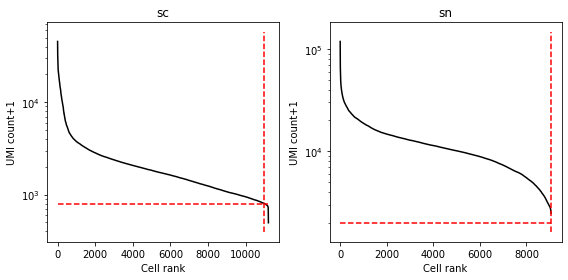

In [12]:
cf = []
thr_lb = [8e2, 2e3]
thr_ub = [1e4, 5e4]

fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

dataset_identifiers = ('C72_RESEQ','C72_TST')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        print(len(bcs))
        knee_plot(S+U,n_cells,ax1[k],viz=True,thr=thr_lb[k])
        ax1[k].set_title(dataset_meta[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
                    
        for cluster in cluster_names:
            cf.append(np.isin(bcs,meta[(meta['sample']==dataset_identifiers[k]) \
                                       & (meta['Manual_Annotation']==cluster)]['cell_barcode'])\
                      & cf_)
fig1.tight_layout()

In [13]:
[x.sum() for x in cf]

[1567, 4421, 991, 2885, 2862, 1879]

## Preprocessing

Identify the genes to fit.

Construct a batch by finding genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria. The v2 part of this dataset is pretty bad, so we have a fairly low threshold (Monod default, but force at least 50% of the datasets to meet it)

In [14]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230621_026_liver_andrews_1 already exists.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:1567 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:516 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep already exists.
INFO:root:Dataset: liver_c72_sc_PortalHep
INFO:root:4421 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:539 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep already exists.
INFO:root:Dataset: liver_c72_sc_InterHep
INFO:root:991 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:393 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230621_026_l

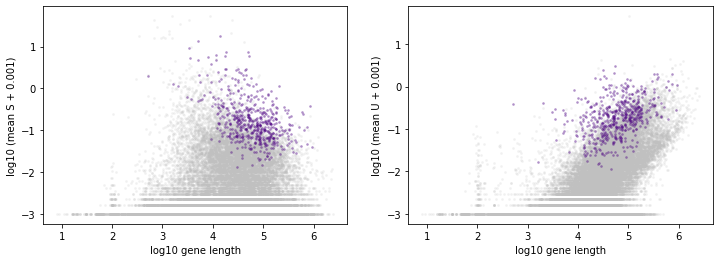

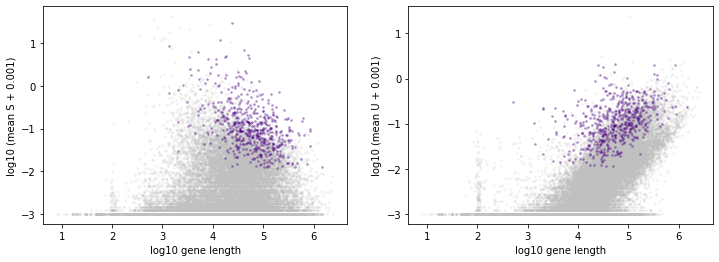

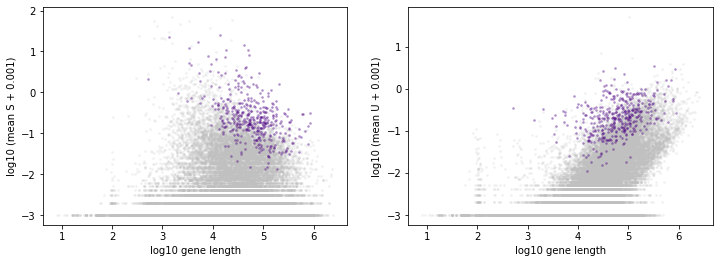

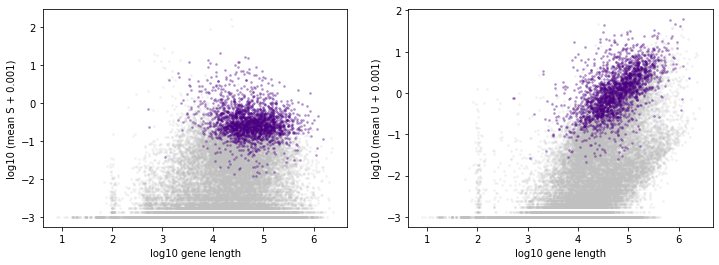

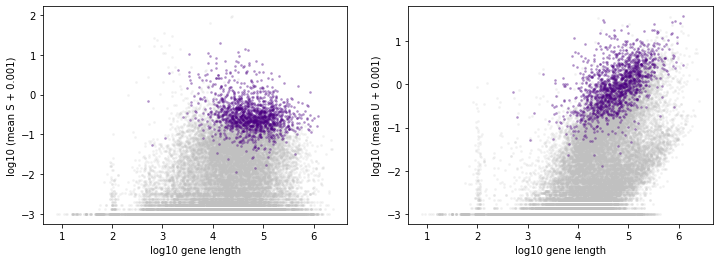

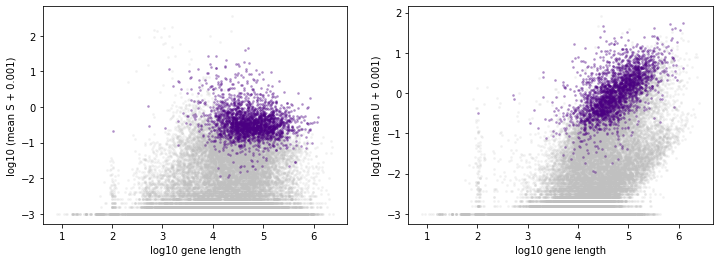

In [17]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_andrews',batch_id=1,\
                                             n_genes=1500,exp_filter_threshold=0.5,cf=cf)

INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230621_026_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_PortalHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230621_026_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_InterHep
INFO:ro

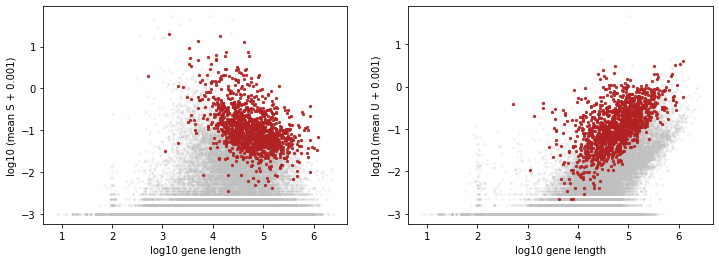

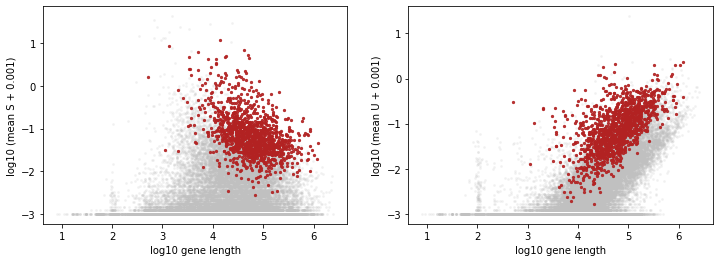

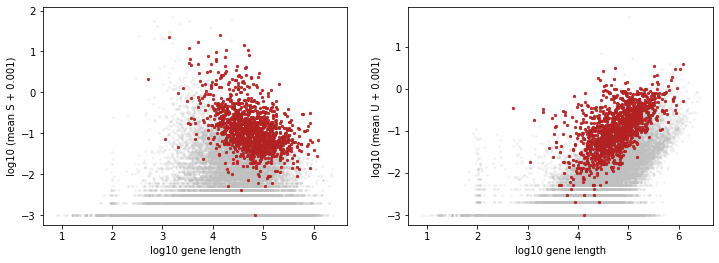

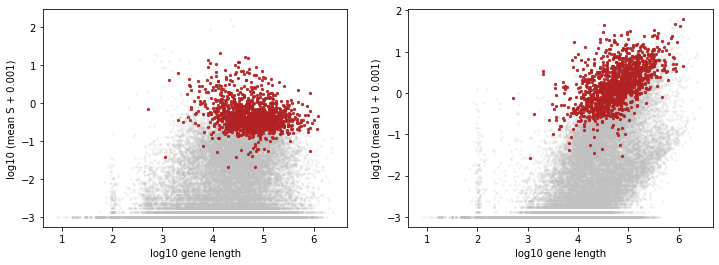

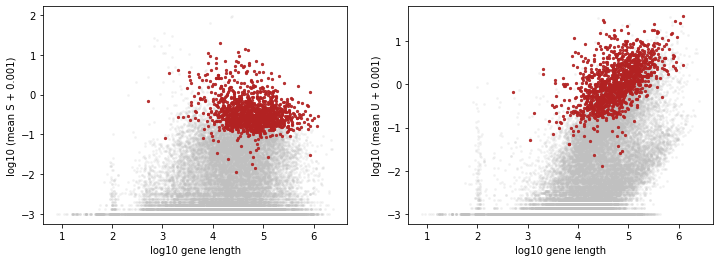

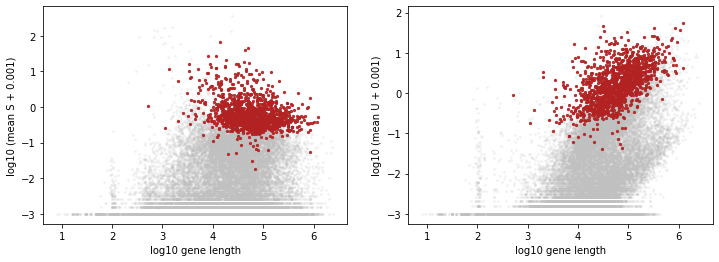

In [20]:
for i in range(n_datasets):
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])


# Inference

In [21]:
import pymc3 as pm
import theano.tensor as tt
import time
import os
import pickle
import tqdm
from tqdm import tqdm

/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/scalar/basic.py:2412: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ctor = getattr(np, o_type.dtype)
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject
/home/ggorin/miniconda3/lib/python3.9/site-packages/arviz/__init__.py:317: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  register_cmap("cet_" + name, cmap=cmap)
/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/tensor/basic.py:369: De

In [22]:
dir_string

'./fits/gg_230621_026_liver_andrews_1'

In [23]:
dataset_strings

['./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep',
 './fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep',
 './fits/gg_230621_026_liver_andrews_1/liver_c72_sc_InterHep',
 './fits/gg_230621_026_liver_andrews_1/liver_c72_sn_CentralHep',
 './fits/gg_230621_026_liver_andrews_1/liver_c72_sn_PortalHep',
 './fits/gg_230621_026_liver_andrews_1/liver_c72_sn_InterHep']

In [24]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood,n_cells):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        self.n_cells = n_cells
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data,self.n_cells) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood


In [29]:
def get_parameter_posteriors_smc(string_ID, mx, data, n_cells, ll_func, draws_=1000, chains_=1, cores_=1):
    """"Arguments changed for sample_smc function. Here is pymc3 3.8"""
    # Define log likelihood
    logl_op = LogLike(mx, data, ll_func, n_cells)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        phi = tt.as_tensor_variable([pm.Uniform(par_names[j], lower=phys_lb[j], upper=phys_ub[j]) for j in range(fitmodel.get_num_params())])
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = time.time()
    with model:
        trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
#     print("--- %s seconds ---" % (time.time() - start_time))        
    return trace

#och this is ugly
def ll_bursty(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_extrinsic(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delay(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delayedsplicing(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)

def smc_wrapper(Input):
    data, mx, n_cells, gene_index, model = Input
#     d_N, d_M = data
#     mx = [np.max(d_N)+10,np.max(d_M)+10]
    if model=='bursty':
        trace_id = 'bursty_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_bursty, chains_=1, cores_=1)
    if model=='extrinsic':
        trace_id = 'extrinsic_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_extrinsic, chains_=1, cores_=1)
    if model=='delay':
        trace_id = 'delay_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delay, chains_=1, cores_=1)
    if model=='delayedsplicing':
        trace_id = 'delayedsplicing_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delayedsplicing, chains_=1, cores_=1)
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'

    with open(smc_path+'/'+trace_id+'.pickle', 'wb') as f:
        
        pickle.dump(trace, f)
    return trace

# Bursty

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [31]:
num_cores = 50
log = logging.getLogger()
log.setLevel(logging.WARNING)

In [34]:

model = 'bursty'
fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['b','beta','gamma']

for dataset_ind in range(6):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

In [36]:

for dataset_ind in range(4,6):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1293/1293 [1:18:26<00:00,  3.64s/it]


In [37]:

model = 'extrinsic'
fitmodel = monod.cme_toolbox.CMEModel('Extrinsic','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','gamma']

for dataset_ind in range(6):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1293/1293 [33:01<00:00,  1.53s/it]


In [38]:

model = 'delay'
fitmodel = monod.cme_toolbox.CMEModel('Delay','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','tauinv']


for dataset_ind in range(6):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1293/1293 [20:04<00:00,  1.07it/s]


In [39]:

model = 'delayedsplicing'
fitmodel = monod.cme_toolbox.CMEModel('DelayedSplicing','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','tauinv','gamma']

for dataset_ind in range(6):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1293/1293 [14:09<00:00,  1.52it/s]


Move results around.

In [40]:
import shutil


In [41]:
result_dir = './fits/smc_fits/'
os.makedirs(result_dir,exist_ok=True)
for dataset_ind in range(6):
    dataset_result_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results/'
    for model in ['bursty','extrinsic','delay','delayedsplicing']:
        dataset_result_file_path = dataset_result_path + model+'_all.pickle'
        destination = result_dir + dataset_names[dataset_ind]+'_'+model+'.pickle'
        print(dataset_result_file_path)
        print(destination)
        print('---')
        shutil.copy(dataset_result_file_path, destination)


./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/smc_results/bursty_all.pickle
./fits/smc_fits/liver_c72_sc_CentralHep_bursty.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/smc_results/extrinsic_all.pickle
./fits/smc_fits/liver_c72_sc_CentralHep_extrinsic.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/smc_results/delay_all.pickle
./fits/smc_fits/liver_c72_sc_CentralHep_delay.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_CentralHep/smc_results/delayedsplicing_all.pickle
./fits/smc_fits/liver_c72_sc_CentralHep_delayedsplicing.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep/smc_results/bursty_all.pickle
./fits/smc_fits/liver_c72_sc_PortalHep_bursty.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep/smc_results/extrinsic_all.pickle
./fits/smc_fits/liver_c72_sc_PortalHep_extrinsic.pickle
---
./fits/gg_230621_026_liver_andrews_1/liver_c72_sc_PortalHep/smc_results/delay_all.